In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
# Load datasets
train_df = pd.read_csv('D:\\mnist_train.csv')  
test_df = pd.read_csv('D:\\mnist_test.csv') 

# Combine datasets
combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print("Combined Data Shape:", combined_df.shape)

# Check for NaNs in features and labels
print("NaNs in Combined Features:", combined_df.drop('label', axis=1).isna().sum().sum())
print("NaNs in Combined Labels:", combined_df['label'].isna().sum())

# Separate features and labels
X_combined = combined_df.drop('label', axis=1)
y_combined = combined_df['label']

Combined Data Shape: (70000, 785)
NaNs in Combined Features: 0
NaNs in Combined Labels: 0


In [3]:
# Impute NaNs in labels
combined_df_clean = combined_df.dropna(subset=['label'])
print("Shape after dropping NaN labels:", combined_df_clean.shape)

# Update X and y after cleaning
X_combined = combined_df_clean.drop('label', axis=1)
y_combined = combined_df_clean['label']

# Preprocessing pipeline for features
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaNs in X with mean
    ('scaler', StandardScaler())                  # Standardize features
])

# Apply preprocessing to features
X_processed = preprocessing_pipeline.fit_transform(X_combined)

# Normalize (already scaled, but explicit for clarity)
X_processed = X_processed / 255.0

# Verify no NaNs
print("NaNs in Processed Features:", np.isnan(X_processed).sum())
print("NaNs in Processed Labels:", np.isnan(y_combined).sum())

Shape after dropping NaN labels: (70000, 785)
NaNs in Processed Features: 0
NaNs in Processed Labels: 0


In [4]:
# Feature selection
selector = SelectKBest(score_func=f_classif, k=200)  # Select top 200 features
X_selected = selector.fit_transform(X_processed, y_combined)

# Get selected feature indices
selected_features = selector.get_support()
print("Number of Features Selected:", X_selected.shape[1])

Number of Features Selected: 200


In [5]:
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (56000, 200)
Testing Set Shape: (14000, 200)


In [6]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'ANN': MLPClassifier(max_iter=1000)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.3f}')
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

# Tune ANN
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'learning_rate_init': [0.001, 0.01]
}
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train[:5000], y_train[:5000])  # Subset for speed; adjust as needed
best_ann = grid_search.best_estimator_
y_pred_tuned = best_ann.predict(X_test)
results['Tuned ANN'] = accuracy_score(y_test, y_pred_tuned)
print(f'Tuned ANN Accuracy: {results["Tuned ANN"]:.3f}')
print(f'Best Parameters: {grid_search.best_params_}')

Logistic Regression Accuracy: 0.796
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1381
           1       0.73      0.98      0.83      1575
           2       0.87      0.74      0.80      1398
           3       0.74      0.82      0.78      1428
           4       0.74      0.79      0.76      1365
           5       0.83      0.58      0.68      1263
           6       0.86      0.88      0.87      1375
           7       0.81      0.89      0.85      1459
           8       0.84      0.71      0.77      1365
           9       0.75      0.61      0.68      1391

    accuracy                           0.80     14000
   macro avg       0.80      0.79      0.79     14000
weighted avg       0.80      0.80      0.79     14000

[[1266    0    9    6    4   33   38    3   21    1]
 [   0 1539   11    5    0    5    5    1    7    2]
 [  36  123 1037   34   33    2   56   43   33    1]
 [  11   52   52 1177    4   39   10   26   40

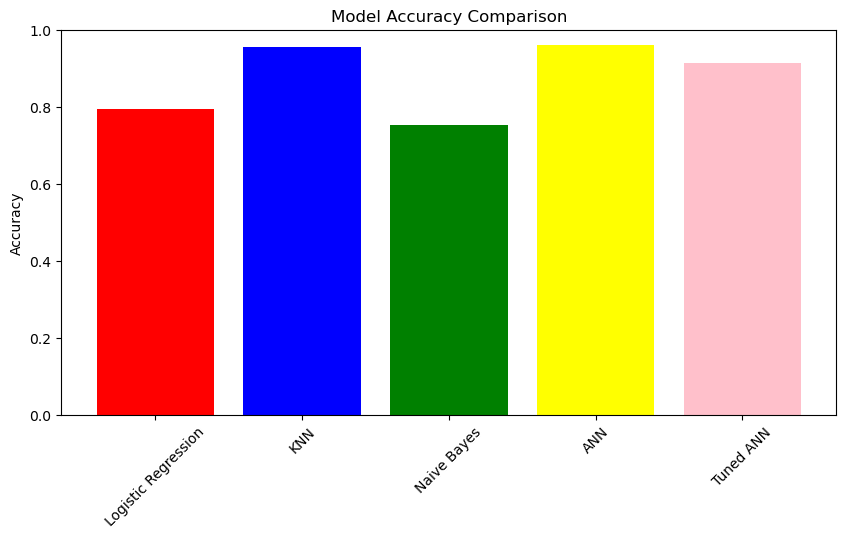

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['red', 'blue', 'green', 'yellow', 'pink'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()